$$
\newcommand{\dd}{\text{d}}
\newcommand{\pdv}[2]{ \frac{\partial #1}{\partial #2}  }
\newcommand{\dv}[2]{ \frac{\dd #1}{\dd #2} }
$$

# Double well potential
__Jared Callaham (2020)__

$$ m \ddot{u} + 2 m \nu \dot{u} + V'(u) = \sigma_u w(t),$$
with $w(t)$ a white noise process and $\sigma_u = \sqrt{ 2 \nu k_B T } $.
We'll look at the double-well potential
$$
V(u) = -\frac{\alpha}{2} u^2 + \frac{\beta}{4}u^4
$$

Nondimensionalize by the mass $m$, the dissipative relaxation timescale $\nu $, and the remaining length scale from the potential $A = \sqrt{\nu^2/\beta}$.
Then
$$
\ddot{x} + 2 \dot{x} = \epsilon x - x^3 + \sigma_x w(t).
$$

The deterministic system goes through a pitchfork bifurcation at $\epsilon = 0$.  The normal form is
$$
\dot{\phi} = \lambda_1 (\epsilon) \phi - \mu (\epsilon) \phi^3 + \sigma_\phi w(t),
$$
where $\lambda_{1, 2} = -1 \pm \sqrt{1 + \epsilon} $.
With the slow manifold approximation $\phi_2 = h \phi_1$, and requiring the fixed points to be consistent, $h = -\lambda_1 / \lambda_2 $ and $\mu = (1 + h)^2 \lambda_1 / \epsilon $.
From the rule for stochastic change of variables, $\sigma_\phi = \sigma_x / 2 \sqrt{1 + \epsilon}$.



### Dependency notes

In addition to the packages shown here, `dwutils.py` calls the PyJulia package to interface with the fast SDE solvers in Julia for solving the full double well problem and also Monte Carlo evaluation of the models.  It's nice, but getting this to work well can be a pain.  Alternatively an [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) solver can be used for evaluation - it's just a lot slower

In [ ]:
import sys
sys.path.insert(0, "/Users/jcallaham/Dropbox/Documents/python")
from time import time
import h5py

# Numpy
import numpy as np
from numpy.linalg import lstsq
import numpy.random as rng

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']    # Default matplotlib colors
color_list[:2] = ["#000000", "#5891BF"]  # Black/blue  

cm = mpl.colors.ListedColormap(color_list)

# Scipy
from scipy.optimize import curve_fit, minimize
from scipy.signal import welch
from scipy import sparse, linalg
from scipy.stats import kurtosis

import sympy

# Custom packages
import utils
import fpsolve
import dwutils as dw

In [83]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import julia
jl = julia.Julia()
jl.include("../sim_doublewell.jl")

<PyCall.jlwrap run_sim>

# 1. Far-from-bifurcation dynamics

In [563]:
eps = 20
sigma = 0.5*(np.sqrt(eps) + eps)
x_eq = np.sqrt(eps)
print(x_eq)

dt = 1e-2
tmax = int(1e5)
t, X = jl.run_sim(eps, sigma, dt, tmax)
X, V = X[0, :], X[1, :]

4.47213595499958


#### Example trajectory

Note that the trajectory is smooth at short times (and has a characteristic oscillation frequency with wells), but at long times it looks "noisy" like the pitchfork bifurcation.  This is the root of the sampling rate problem: the second-order problem cannot formally be modeled by a first-order Langevin equation far from the bifurcation due to non-Markovian effects from discarding the extra degree of freedom.

To get around this we can sample coarsely enough that only the long-time switching is captured.

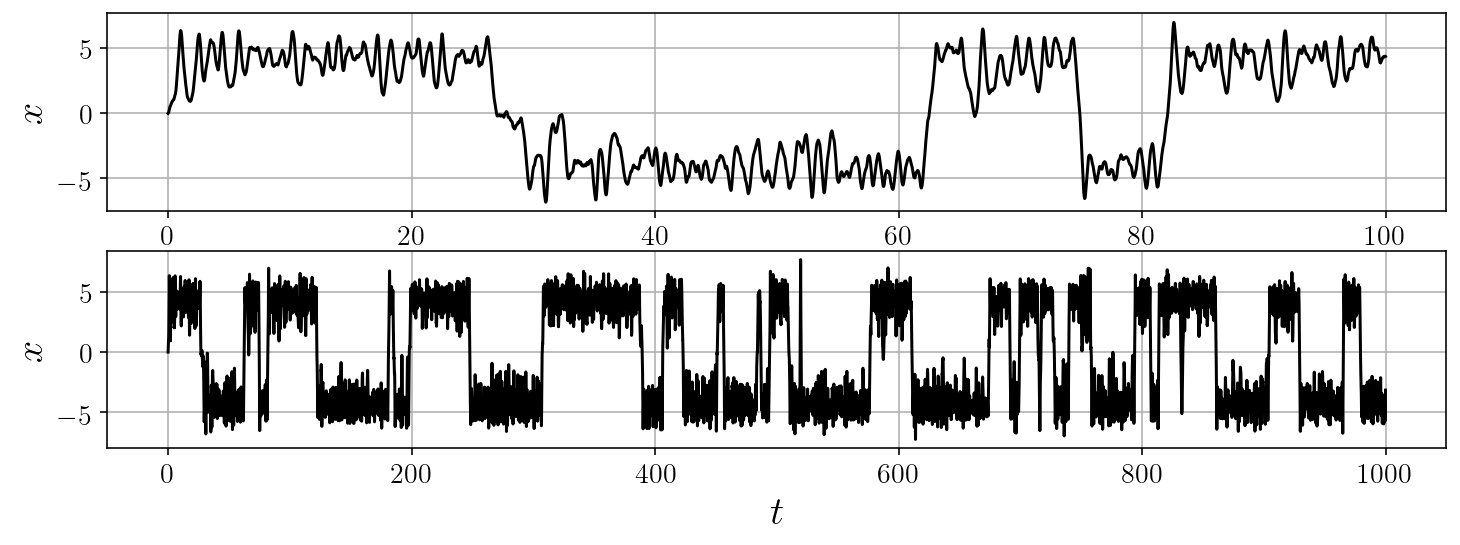

In [567]:
plt.figure(figsize=(12, 4))

plt.subplot(211)
tmax = np.nonzero(t>100)[0][0]
stride=1
plt.plot(t[:tmax:stride], X[:tmax:stride], 'k')
plt.ylabel('$x$')
plt.grid()

plt.subplot(212)
tmax = np.nonzero(t>1000)[0][0]
stride=1
plt.plot(t[:tmax:stride], X[:tmax:stride], 'k')
plt.ylabel('$x$')
plt.xlabel("$t$")
plt.grid()
plt.show()

In [631]:
# PDF of states

N = 32
edges = np.linspace(-2*x_eq, 2*x_eq, N+1)
centers = 0.5*(edges[1:]+edges[:-1])
p_hist = np.histogram(X, edges, density=True)[0]
#p_hist = 0.5*(p_hist + np.flip(p_hist))  # Symmetrize

# PDF of switching times
dt = t[2]-t[1]
state = dw.switched_states(X, thresh=x_eq)

# PDF of switching times
switch_times = dw.dwell_times(state, dt=dt)

print(len(switch_times))
print(max(switch_times))

bins = np.linspace(0, 8*np.mean(switch_times), 15)

db = bins[1]-bins[0]
dwell_centers = (bins[:-1]+bins[1:])/2
pd = np.histogram(switch_times, bins)[0]
pd_err = np.sqrt(pd)/np.trapz(pd, dx=db)
pd = pd/np.trapz(pd)

# Fit to exponential
slope, cov = np.polyfit(dwell_centers[pd > 1e-12], np.log(pd[pd > 1e-12]), deg=1, cov=True)
slope_err = np.sqrt(cov[0, 0])
slope = slope[0]

print("Data mean: {0:0.3f}".format(np.mean(switch_times)))
print("Data slope: {0:0.3f} +/- {1:0.3f}".format(slope, slope_err))

5096
141.36
Data mean: 19.623
Data slope: -0.050 +/- 0.001


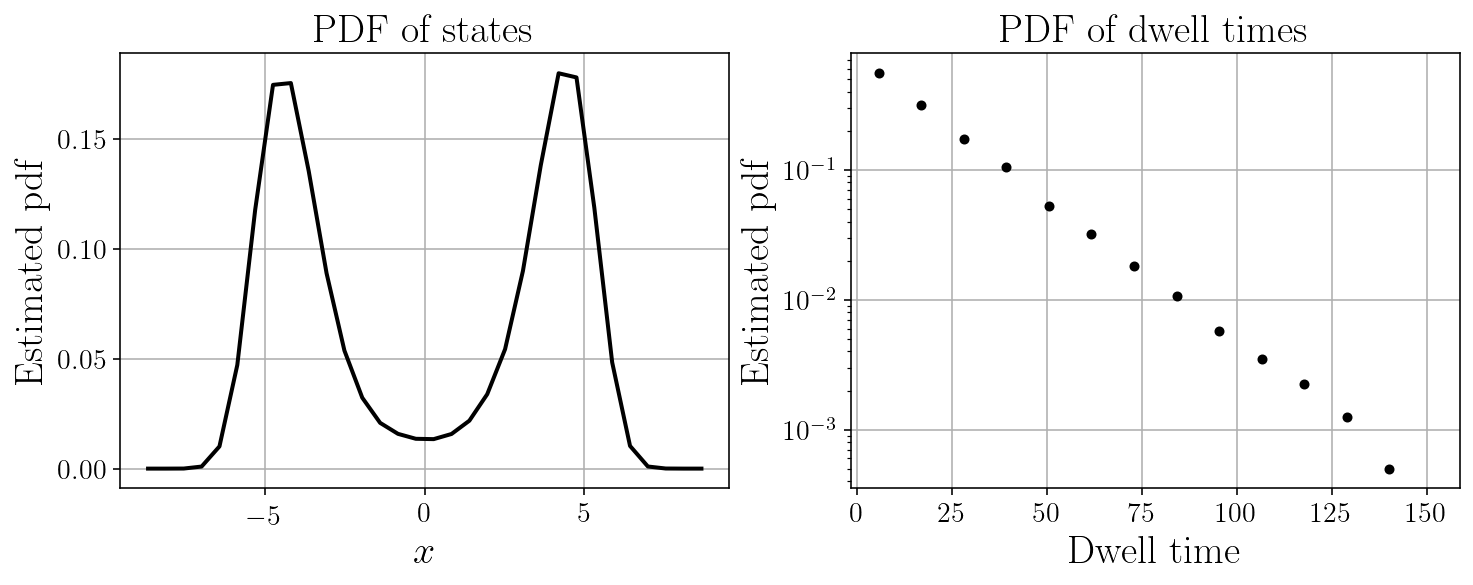

In [632]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.plot(centers, p_hist, 'k', lw=2)
#plt.gca().set_yscale('log')
#plt.ylim([1e-2, 1e1])
plt.title('PDF of states')
plt.xlabel('$x$')
plt.ylabel('Estimated pdf')
plt.grid()

plt.subplot(122)
plt.errorbar(dwell_centers, pd, yerr=pd_err, c='k', ls='', marker='o', ms=4)
plt.gca().set_yscale('log')
plt.title('PDF of dwell times')

plt.xlabel('Dwell time')
plt.ylabel('Estimated pdf')
plt.grid()
plt.show()

### Normal form

See appendix of the paper for derivation.  This works well close to the bifurcation $\epsilon \ll 1$, but in this case we are way too far from the region of validity of this model.

In [572]:
lamb1 = -1 + np.sqrt(1 + eps)
lamb2 = -1 - np.sqrt(1 + eps)
h = -lamb1/lamb2
mu = -(1+h)**2*lamb1/eps
print(h, mu)

dt = 1e-2
tmax = int(1e5)
_, phi1 = jl.run_nf(lamb1, mu, sigma/(2*np.sqrt(1+eps)), dt, tmax)
X_nf = (1+h)*phi1[0, :]

0.641742430504416 -0.4828090751288716


In [ ]:
switch_nf = dw.dwell_times( dw.switched_states(X_nf, thresh=x_eq), dt=dt)

pd_nf = np.histogram(switch_nf, bins)[0]
pd_nf_err = np.sqrt(pd_nf)/np.trapz(pd_nf, dx=db)
pd_nf = pd_nf/np.trapz(pd_nf)

# Fit to exponential
if len(switch_nf)>0:
    slope_nf, cov = np.polyfit(dwell_centers[pd_nf > 1e-12], np.log(pd_nf[pd_nf > 1e-12]), deg=1, cov=True)
    slope_nf_err = np.sqrt(cov[0, 0])
    slope_nf = slope_nf[0]
else:
    slope_nf, slope_nf_err = np.nan, np.nan

# Mean escape times
print("Data mean: {0:0.3f}".format(np.mean(switch_times)))
print("Normal form mean: {0:0.3f}".format(np.mean(switch_nf)))

print("Slope: {0:0.3f} +/- {1:0.3f}".format(slope, slope_err))
print("NF slope: {0:0.3f} +/- {1:0.3f}".format(slope_nf, slope_nf_err))

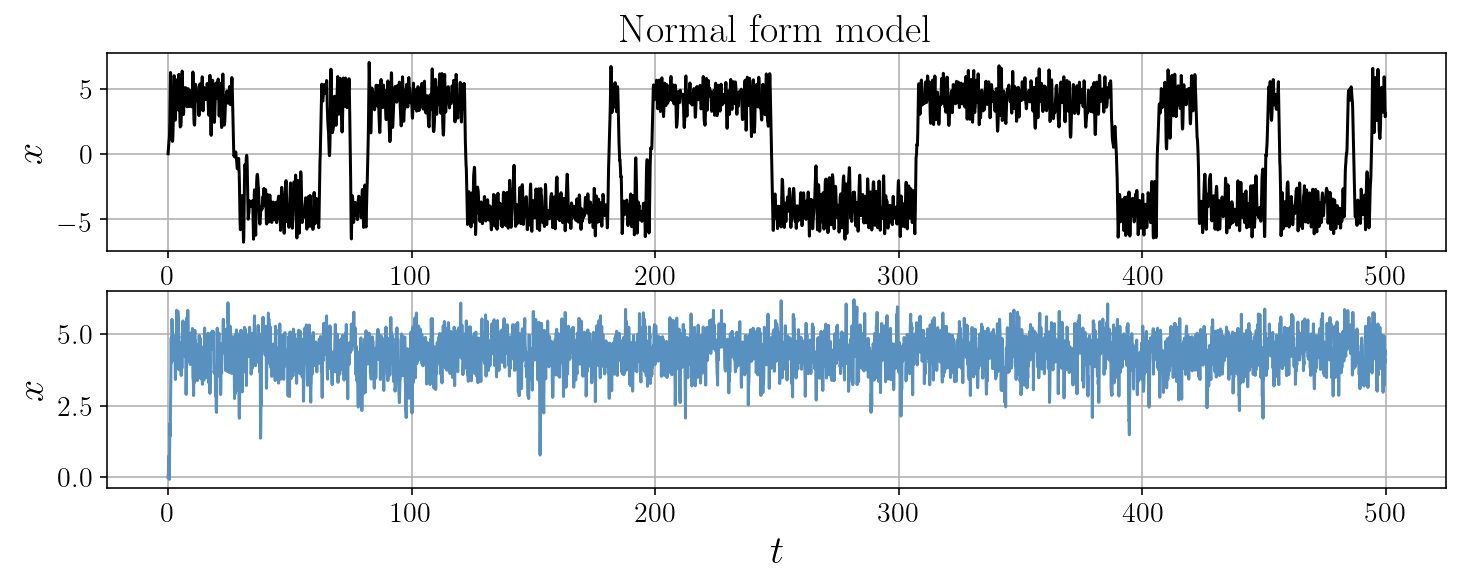

In [574]:
plt.figure(figsize=(12, 4))

tmax = np.nonzero(t>500)[0][0]

plt.subplot(211)
stride=10
plt.plot(t[:tmax:stride], X[:tmax:stride], c=cm(0))
plt.ylabel('$x$')
plt.title('Normal form model')
plt.grid()

plt.subplot(212)
stride=10
plt.plot(t[:tmax:stride], X_nf[:tmax:stride], c=cm(1))
plt.ylabel('$x$')
plt.xlabel("$t$")
plt.grid()
plt.show()

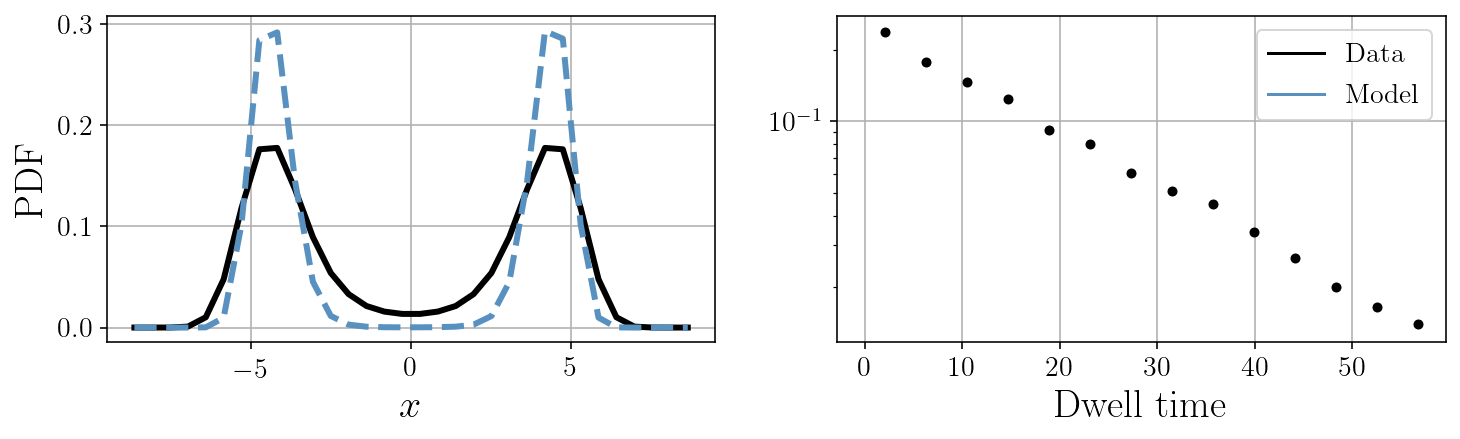

In [575]:
p_nf = np.histogram(X_nf, edges, density=True)[0]

plt.figure(figsize=(12, 3))

plt.subplot(121)
plt.plot(centers, 0.5*(p_hist + np.flip(p_hist)), c=cm(0), lw=3)
plt.plot(centers, p_nf, c=cm(1), ls='--', lw=3)
plt.xlabel('$x$')
plt.ylabel('PDF')
plt.grid()

plt.subplot(122)
plt.errorbar(dwell_centers, pd, yerr=pd_err, c=cm(0), ls='', marker='o', ms=4)
plt.errorbar(dwell_centers, pd_nf, yerr=pd_nf_err, c=cm(1), ls='', marker='^', ms=6)
plt.plot([0], [0], c=cm(0), label='Data')
plt.plot([0], [0], c=cm(1), label='Model')
plt.legend(fontsize=14)
plt.gca().set_yscale('log')

plt.xlabel('Dwell time')
plt.grid()
plt.show()

# Langevin regresion

First, we have to choose a sampling rate (see Appendix A for explanations of the various approaches to this)

Tau ~ 3.78


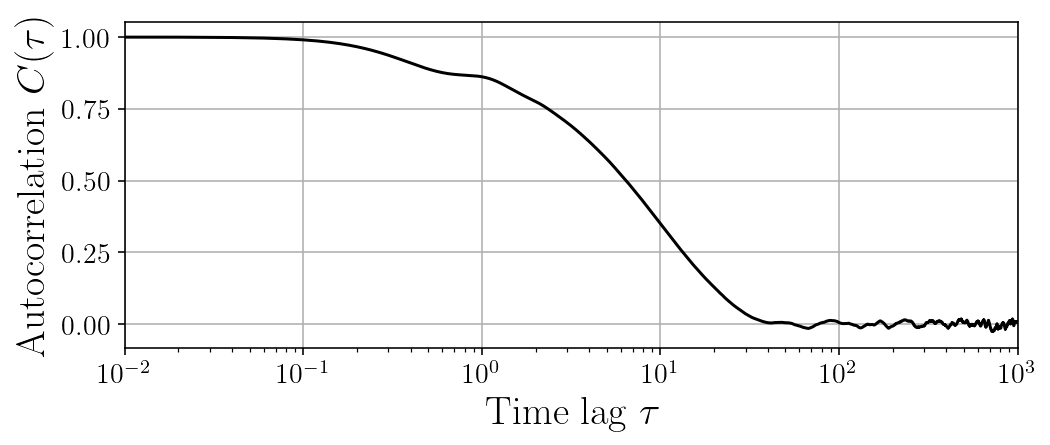

In [585]:
# Autocorrelation function

acf = utils.autocorr_func_1d(X)

tau = dt*np.arange(0, len(X))
fit_mask = np.nonzero(tau < 0.5)[0]
fit = np.polyfit(tau[fit_mask], np.log(acf[fit_mask]), deg=1)
print("Tau ~ {0:0.2f}".format(-1/fit[0]))

plt.figure(figsize=(8, 3))

plt.plot(tau, acf, 'k')
#plt.plot(tau[fit_mask], np.exp(np.polyval(fit, tau[fit_mask])), c=mpl_colors[1], ls='--', lw=2)

plt.ylabel(r'Autocorrelation $C(\tau)$')
plt.xlabel(r'Time lag $\tau$')

#plt.ylim([1e-2, 1.1])
plt.xlim([1e-2, 1e3])
plt.gca().set_xscale('log')

plt.grid()
plt.show()

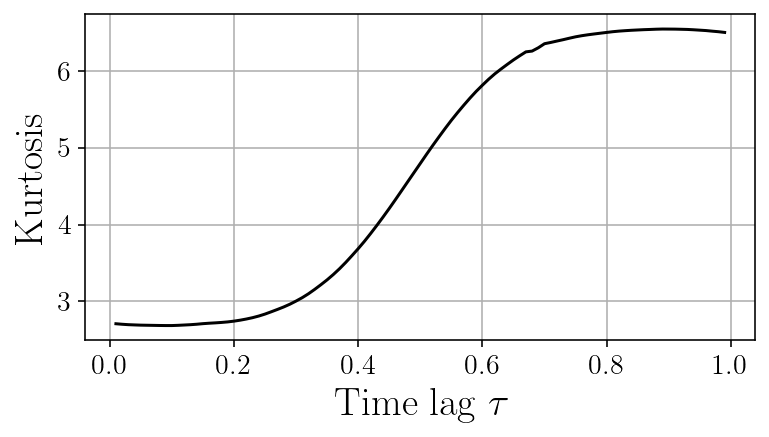

In [499]:
# Plot mean kurtosis vs lag

lag = np.arange(1, 100, 1)
kurt = np.zeros(lag.shape)

for j in range(len(lag)):
    tau = lag[j]*dt
    dX = (X[lag[j]:] - X[:-lag[j]])/tau  # Step (finite-difference derivative estimate)

    for i in range(N):
        # Find where signal falls into this bin
        mask = (X[:-lag[j]] > edges[i]) * (X[:-lag[j]] < edges[i+1])
        mask_idx = np.nonzero(mask)[0]
        if len(mask_idx)>0:
            kurt[j] += kurtosis(dX[mask_idx], fisher=False)

kurt = kurt/N # Average over domain

plt.figure(figsize=(6, 3))
plt.plot(dt*lag, kurt, 'k')
plt.grid()
plt.xlabel(r'Time lag $\tau$')
plt.ylabel('Kurtosis')
plt.show()

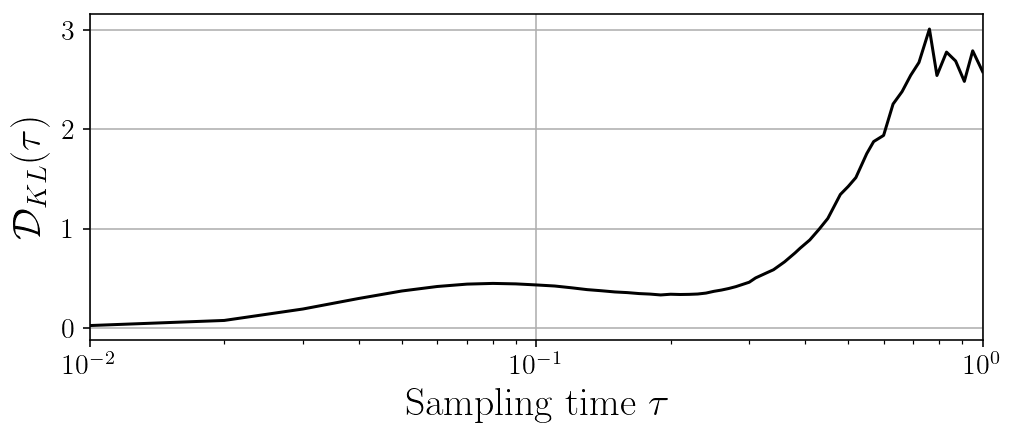

In [587]:
# Markov test

utils = reload(utils)
lag = np.round( np.logspace(0, 2, 100) ).astype(int)
kl_div = np.array([utils.markov_test(X, delta, N=16) for delta in lag])

plt.figure(figsize=(8, 3))
plt.gca().set_xscale('log')
plt.plot(dt*lag, kl_div, 'k')

plt.ylabel(r'$\mathcal{D}_{KL}(\tau)$')
plt.xlabel(r'Sampling time $\tau$')
plt.xlim([1e-2, 1e0])
plt.grid()

Based on these results, $\tau = 0.2$ seems consistent with all of these metrics

In [588]:
# Plot truth, fast sampling, slow sampling
stride = 20
tau = stride*dt
print("Tau: {0}".format(tau))

Y = X[::stride] 
dY = (Y[1:] - Y[:-1])/tau  # Step (finite-difference derivative estimate)
dY2 = (Y[1:] - Y[:-1])**2/tau  # Conditional variance

dX = (X[1:] - X[:-1])/dt  # Step (finite-difference derivative estimate)
dX2 = (X[1:] - X[:-1])**2/dt  # Conditional variance

f_fine = np.zeros(centers.shape)
a_fine = np.zeros(centers.shape)
f_fine_err = np.zeros(centers.shape)
a_fine_err = np.zeros(centers.shape)
f_KM = np.zeros(centers.shape)
a_KM = np.zeros(centers.shape)
f_err = np.zeros(centers.shape)
a_err = np.zeros(centers.shape)

for i in range(len(edges)-1):
    # Fine sampling
    mask = np.nonzero( (X[:-1] > edges[i]) * (X[:-1] < edges[i+1]) )[0]
    
    if len(mask)>0:
        f_fine[i] = np.mean(dX[mask]) # Conditional average
        a_fine[i] = 0.5*np.mean(dX2[mask]) # Conditional average
        f_fine_err[i] = np.std(dX[mask])/np.sqrt(len(mask))
        a_fine_err[i] = np.std(dX2[mask])/np.sqrt(len(mask))
    else:
        f_fine[i], a_fine[i] = np.nan, np.nan

    # Coarse sampling
    mask = np.nonzero((Y[:-1] > edges[i]) * (Y[:-1] < edges[i+1]) )[0]
    if len(mask)>0:
        f_KM[i] = np.mean(dY[mask]) # Conditional average
        a_KM[i] = 0.5*np.mean(dY2[mask]) # Conditional average
        f_err[i] = np.std(dY[mask])/np.sqrt(len(mask))
        a_err[i] = np.std(dY2[mask])/np.sqrt(len(mask))
    else:
        f_KM[i], a_KM[i] = np.nan, np.nan
        f_err[i], a_err[i] = np.nan, np.nan

Tau: 0.2


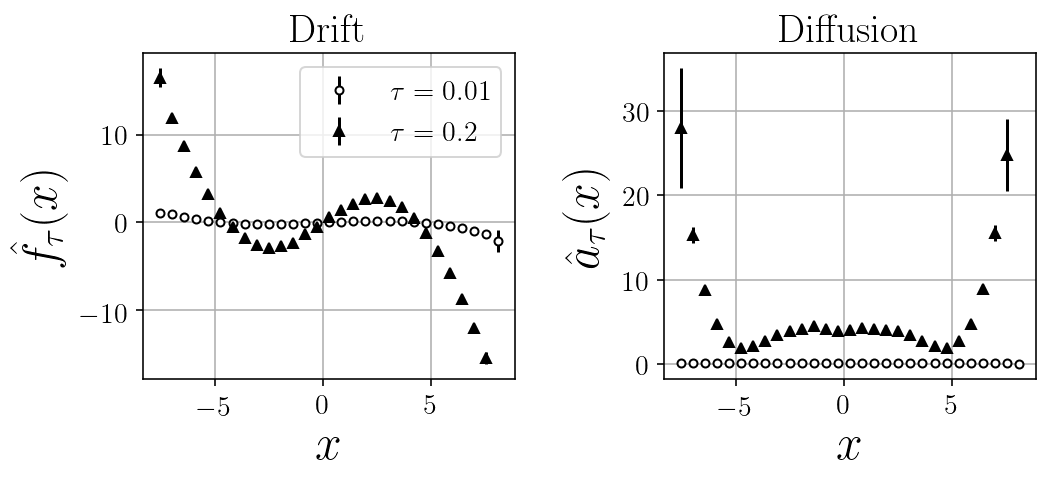

In [589]:


plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.errorbar(centers, f_fine, yerr=f_fine_err, ls='', marker='.', markersize=8, 
             c='k', markerfacecolor='w', label=r'$\tau = {{{0}}}$'.format(dt))
plt.errorbar(centers, f_KM, yerr=f_err, ls='', marker='^', markersize=5, 
             c='k', label=r'$\tau = {{{0}}}$'.format(tau))
plt.title('Drift')
plt.xlabel('$x$', fontsize = 24)
plt.ylabel(r'$\hat{f}_\tau(x)$', fontsize = 24)
plt.grid()
plt.legend(fontsize=14)
#plt.xlim([-1.8, 1.8])
#plt.ylim([-4, 4])


plt.subplot(122)
plt.errorbar(centers, a_fine, yerr=a_fine_err, ls='', marker='.', markersize=8, 
             c='k', markerfacecolor='w')
plt.errorbar(centers, a_KM, yerr=a_err, ls='', marker='^', markersize=5, 
             c='k')
plt.title('Diffusion')
plt.xlabel('$x$', fontsize = 24)
plt.ylabel(r'$\hat{a}_\tau(x)$', fontsize = 24)
plt.grid()
#plt.xlim([-1.8, 1.8])
#plt.ylim([0, 2])

plt.subplots_adjust(wspace=0.4)
plt.show()

### AFP optimization

Also see pitchfork notebook for SSR model selection

In [590]:
### Build libraries
x = sympy.symbols('x')

f_expr = np.array([x**i for i in [1, 3]])  # Polynomial library for drift
s_expr = np.array([x**i for i in [0]])  # Polynomial library for diffusion

lib_f = np.zeros([len(f_expr), N])
for k in range(len(f_expr)):
    lamb_expr = sympy.lambdify(x, f_expr[k])
    lib_f[k] = lamb_expr(centers)

lib_s = np.zeros([len(s_expr), N])
for k in range(len(s_expr)):
    lamb_expr = sympy.lambdify(x, s_expr[k])
    lib_s[k] = lamb_expr(centers)
    
# Initialize Xi
Xi0 = np.zeros((len(f_expr) + len(s_expr)))
mask = np.nonzero(np.isfinite(f_KM))[0]
Xi0[:len(f_expr)] = lstsq( lib_f[:, mask].T, f_KM[mask], rcond=None)[0]
Xi0[len(f_expr):] = lstsq( lib_s[:,mask].T, np.sqrt(2*a_KM[mask]), rcond=None)[0]

print(Xi0)

[ 1.23192125 -0.06075281  3.2822245 ]


In [591]:
### Weights: uncertainties in Kramers-Moyal
W = np.array((f_err.flatten(), a_err.flatten()))
W[np.less(abs(W), 1e-12, where=np.isfinite(W))] = 1e6  # Set zero entries to large weights
W[np.logical_not(np.isfinite(W))] = 1e6                 # Set NaN entries to large numbers (small weights)
W = 1/W  # Invert error for weights
W = W/np.nansum(W.flatten())

# PDF
p_hist = np.histogram(X, edges, density=True)[0]

# Adjoint solver
afp = fpsolve.AdjFP(centers)

# Forward solver
fp = fpsolve.SteadyFP(N, centers[1]-centers[0])

params = {"W": W, "f_KM": f_KM, "a_KM": a_KM, "Xi0": Xi0,
          "f_expr": f_expr, "s_expr": s_expr,
          "lib_f": lib_f.T, "lib_s": lib_s.T, "N": N,
          "kl_reg": 10,
          "fp": fp, "afp": afp, "p_hist": p_hist, "tau": tau,
          "radial": False}

Xi, V = utils.AFP_opt(dw.cost, params)
print(Xi)

%%%% Optimization time: 0.28477907180786133 seconds,   Cost: 0.37582076200823966 %%%%
[ 2.23462633 -0.11412106  2.82426001]


In [592]:
Xi_f = Xi[:len(f_expr)]
Xi_s = Xi[len(f_expr):]

# Functions from the expressions

f_sindy = sympy.lambdify(x, utils.sindy_model(Xi_f, f_expr))
s_sindy = sympy.lambdify(x, utils.sindy_model(Xi_s, s_expr))
a_sindy = lambda x: 0.5*s_sindy(x)**2

f_vals = f_sindy(centers)
a_vals = a_sindy(centers)

# Check if a scalar (happens when library is a constant)
if np.isscalar(a_vals):
    a_vals = a_vals + 0*centers
if np.isscalar(f_vals):
    f_vals = f_vals + 0*centers

KL divergence (LINDy model): 0.00300


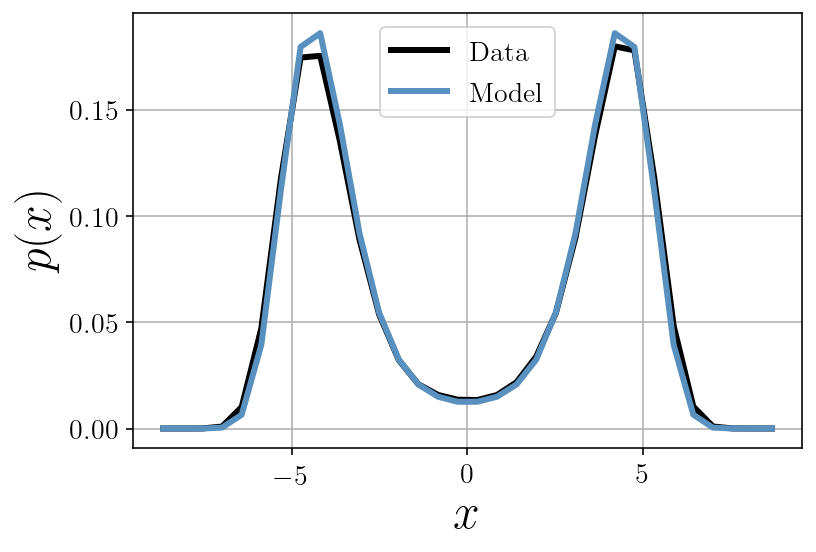

In [593]:
# Compare PDFs

p_fit = fp.solve(f_vals, a_vals)
print('KL divergence (LINDy model): {0:0.5f}'.format(utils.kl_divergence(p_hist, p_fit, dx=fp.dx, tol=1e-6)))

plt.figure(figsize=(6, 4))
plt.plot(centers, p_hist, c=cm(0), label='Data', lw=3)
plt.plot(centers, p_fit, '-', c=cm(1), label='Model', lw=3)
plt.legend(fontsize=14)
#plt.gca().set_yscale('log')
#plt.xlim([0, 3])
plt.xlabel('$x$', fontsize = 24)
plt.ylabel('$p(x)$', fontsize = 24)
plt.grid()

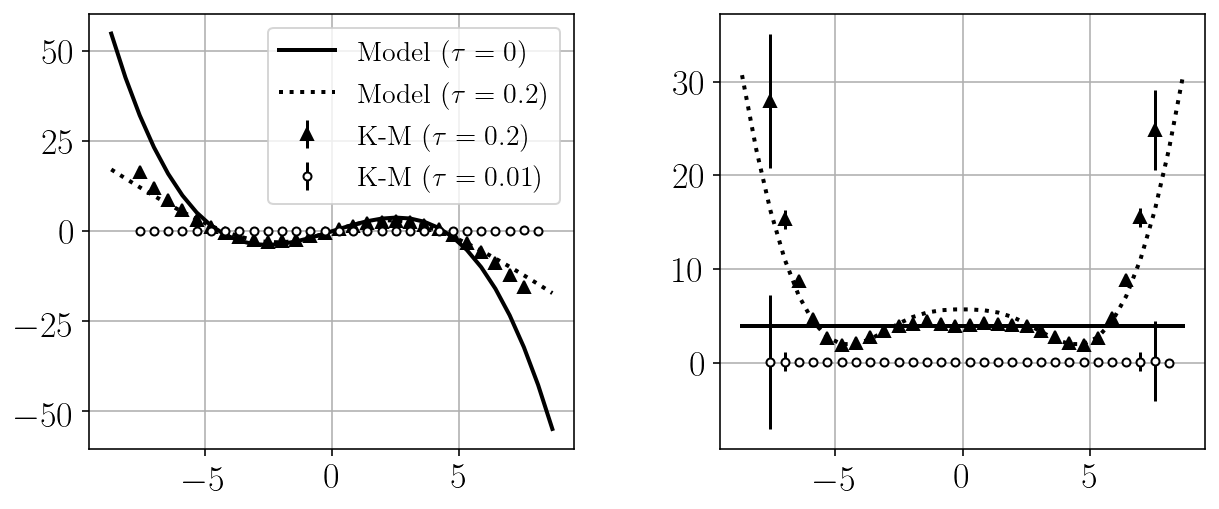

In [667]:
# Plot predicted finite-time evolution
afp.precompute_operator(f_vals, a_vals)
f_tau, a_tau = afp.solve(tau)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.errorbar(centers, f_KM, f_err, ls='', marker='^', markersize=6, 
             c='k', label=r'K-M  ($\tau = {{{0}}}$)'.format(tau))
plt.errorbar(centers, a_fine, yerr=a_fine_err, ls='', marker='.', markersize=8, 
             c='k', markerfacecolor='w', label=r'K-M  ($\tau = {{{0}}}$)'.format(dt))
plt.plot(centers, f_vals, 'k', lw=2, label=r'Model ($\tau = 0$)')
plt.plot(centers, f_tau, 'k:', lw=2, label=r'Model ($\tau = {{{0}}}$)'.format(tau))
#plt.title('Drift')
plt.legend(fontsize=14)
#plt.xlabel('$x$', fontsize = 24)
#plt.ylabel('$f(x)$', fontsize = 24)
plt.grid()
plt.gca().tick_params(labelsize=18)


plt.subplot(122)
plt.errorbar(centers, a_KM, a_err, ls='', marker='^', markersize=6, 
             c='k', label=r'K-M  ($\tau = {{{0}}}$)'.format(tau))
plt.errorbar(centers, a_fine, a_err, ls='', marker='.', markersize=8, 
             c='k', markerfacecolor='w', label=r'K-M  ($\tau = {{{0}}}$)'.format(dt))
plt.plot(centers, a_vals, 'k', lw=2, label=r'Model ($\tau = 0$)')
plt.plot(centers, a_tau, 'k:', lw=2, label=r'Model ($\tau = {{{0}}}$)'.format(tau))
#plt.title('Diffusion')
#plt.xlabel('$x$', fontsize = 24)
#plt.ylabel('$a(x)$', fontsize = 24)
plt.grid()
plt.gca().tick_params(labelsize=18)

plt.subplots_adjust(wspace=0.3)
plt.show()

### Monte Carlo validation of the models

Compare against the PDF and the distribution of dwell times

In [643]:
# Can reuse normal form code for pitchfork models

dt = 1e-2
tmax = int(1e5)
_, X_lr = jl.run_nf(Xi[0], Xi[1], Xi[2], dt, tmax)
X_lr = X_lr[0, :]

In [644]:
switch_lr = dw.dwell_times( dw.switched_states(X_lr, thresh=1), dt=dt)

pd_lr = np.histogram(switch_lr, bins)[0]
pd_lr_err = np.sqrt(pd_lr)/np.trapz(pd_lr, dx=db)
pd_lr = pd_lr/np.trapz(pd_lr)

# Fit to exponential
slope_lr, cov = np.polyfit(dwell_centers[pd_lr > 1e-12], np.log(pd_lr[pd_lr > 1e-12]), deg=1, cov=True)
slope_lr_err = np.sqrt(cov[0, 0])
slope_lr = slope_lr[0]

# Mean escape times
print("Data mean: {0:0.3f}".format(np.mean(switch_times)))
print("Normal form mean: {0:0.3f}".format(np.mean(switch_nf)))
print("Langevin regression mean: {0:0.3f}".format(np.mean(switch_lr)))

print("Slope: {0:0.3f} +/- {1:0.3f}".format(slope, slope_err))
print("NF slope: {0:0.3f} +/- {1:0.3f}".format(slope_nf, slope_nf_err))
print("LR slope: {0:0.3f} +/- {1:0.3f}".format(slope_lr, slope_lr_err))

Data mean: 19.623
Normal form mean: 2096.337
PDF fit mean: 30.084
Langevin regression mean: 20.871
Slope: -0.050 +/- 0.001
NF slope: -0.007 +/- 0.003
PDF slope: -0.033 +/- 0.002
LR slope: -0.038 +/- 0.001


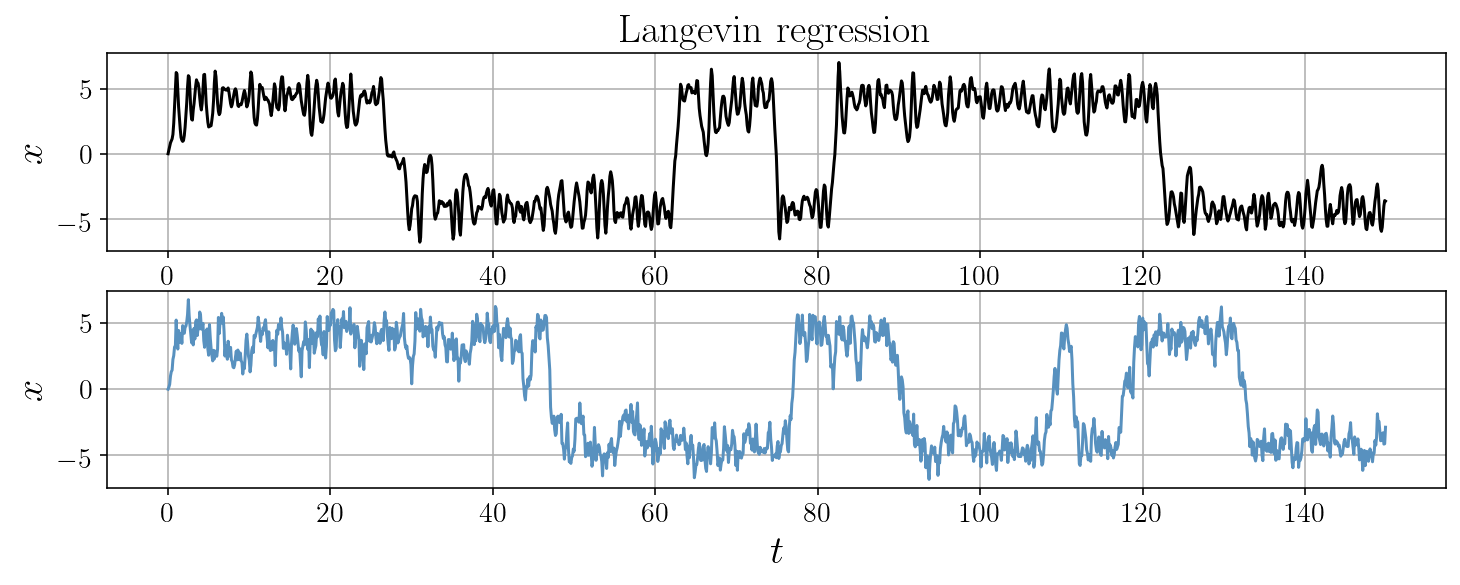

In [645]:
plt.figure(figsize=(12, 4))

tmax = np.nonzero(t>150)[0][0]

plt.subplot(211)
stride=10
plt.plot(t[:tmax:stride], X[:tmax:stride], c=cm(0))
plt.ylabel('$x$')
plt.title('Langevin regression')
plt.grid()

plt.subplot(212)
stride=10
plt.plot(t[:tmax:stride], X_lr[:tmax:stride], c=cm(1))
plt.ylabel('$x$')
plt.xlabel("$t$")
plt.grid()
plt.show()

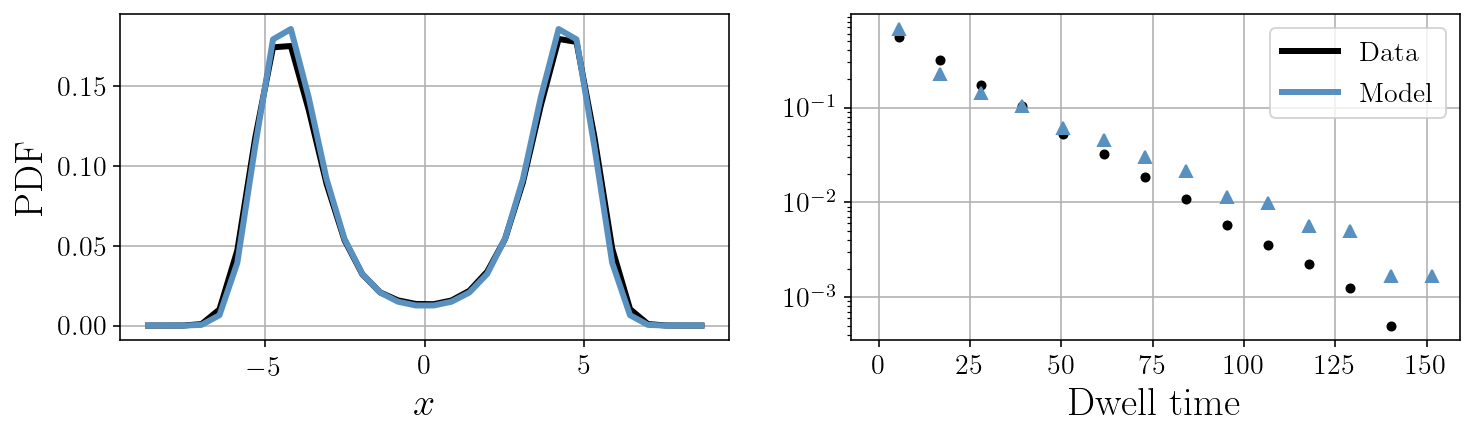

In [646]:
plt.figure(figsize=(12, 3))

plt.subplot(121)
plt.plot(centers, p_hist, c=cm(0), lw=3)
plt.plot(centers, p_fit, c=cm(1), ls='-', lw=3)
plt.xlabel('$x$')
plt.ylabel('PDF')
plt.grid()

plt.subplot(122)
plt.errorbar(dwell_centers, pd, yerr=pd_err, c=cm(0), ls='', marker='o', ms=4)
plt.errorbar(dwell_centers, pd_lr, yerr=pd_lr_err, c=cm(1), ls='', marker='^', ms=6)
plt.plot([0], [0], c=cm(0), lw=3, label='Data')
plt.plot([0], [0], c=cm(1), lw=3, label='Model')
plt.legend(fontsize=14)
plt.gca().set_yscale('log')

plt.xlabel('Dwell time')
plt.grid()
plt.show()

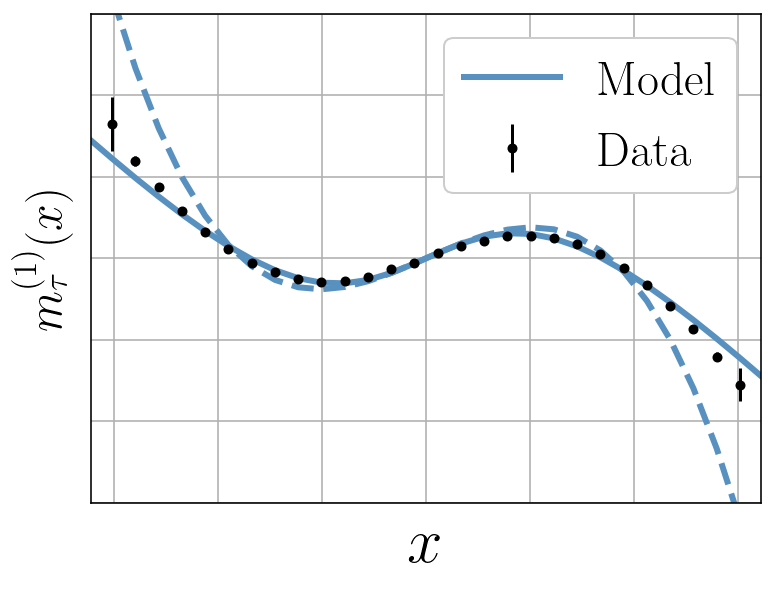

In [621]:
# Plot predicted finite-time evolution of Kramers-Moyal coefficients
afp.precompute_operator(f_vals, a_vals)
f_tau, a_tau = afp.solve(tau)

plt.figure(figsize=(6, 4.5))
plt.errorbar(centers, f_KM, 3*f_err, ls='', marker='.', markersize=8, 
             c='k', label=r'Data')
plt.plot(centers, f_vals, c=cm(1), lw=3, ls='--')
plt.plot(centers, f_tau, c=cm(1), lw=3, label=r'Model')
plt.legend(fancybox=True, framealpha=1, fontsize=24, loc=1)
plt.xlabel('$x$', fontsize=32)
plt.ylabel(r'$m^{(1)}_\tau(x)$', fontsize=24)
plt.grid()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.gca().tick_params('both', length=0)
plt.xlim([-1.8*x_eq, 1.8*x_eq])
plt.ylim([-30, 30])

plt.show()

# 2. Near-bifurcation regime ($\epsilon = 0.1$)

Here the normal form also works very well

In [121]:
eps = 0.1
x_eq = np.sqrt(eps)  # Equilibrium value

# Potential
U = lambda x: -0.5*eps*x**2 + 0.25*x**4
Umin = U(x_eq)
print(Umin)

sigma = 0.5*(np.sqrt(eps) + eps)
#sigma = np.sqrt(-2*Umin)
print(sigma)

dt = 1e-2
tmax = int(1e5)
t, X = jl.run_sim(eps, sigma, dt, tmax)
X, V = X[0, :], X[1, :]

-0.002500000000000001
0.208113883008419


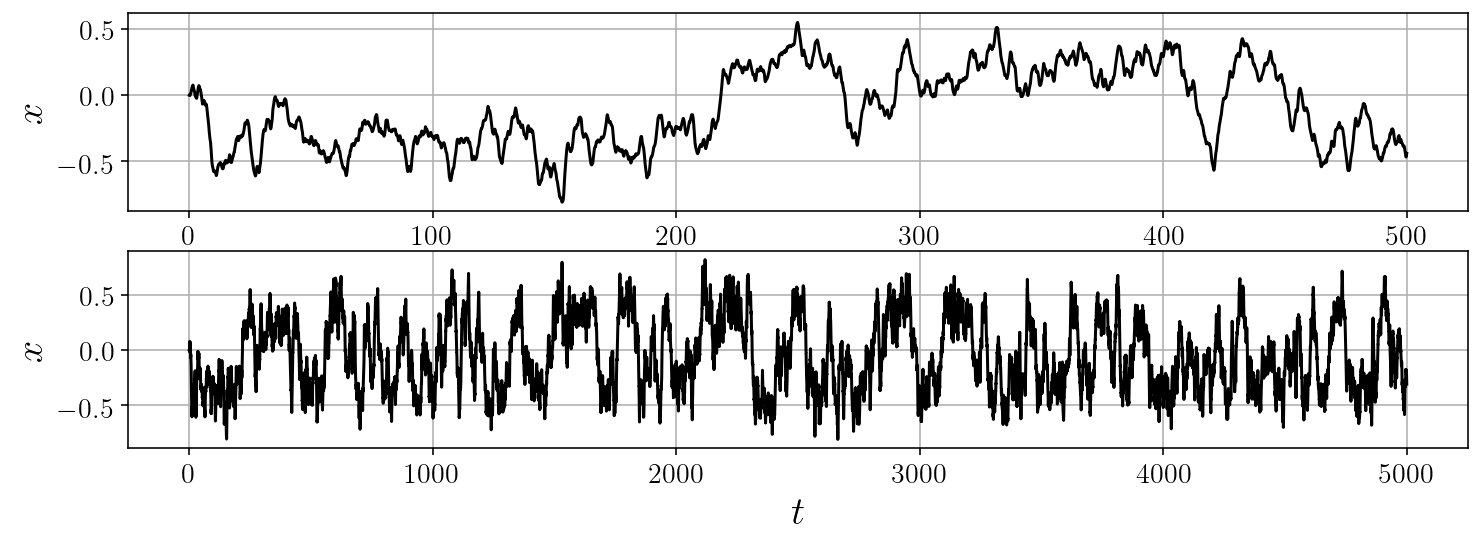

In [123]:
plt.figure(figsize=(12, 4))

plt.subplot(211)
tmax = np.nonzero(t>500)[0][0]
stride=1
plt.plot(t[:tmax:stride], X[:tmax:stride], 'k')
plt.ylabel('$x$')
plt.grid()

plt.subplot(212)
tmax = np.nonzero(t>5000)[0][0]

stride=1
plt.plot(t[:tmax:stride], X[:tmax:stride], 'k')
plt.ylabel('$x$')
plt.xlabel("$t$")
plt.grid()
plt.show()

In [125]:
# PDF of states

N = 40
edges = np.linspace(-2*x_eq, 2*x_eq, N+1)
centers = 0.5*(edges[1:]+edges[:-1])
p_hist = np.histogram(X, edges, density=True)[0]
#p_hist = 0.5*(p_hist + np.flip(p_hist))  # Symmetrize

# PDF of switching times
dt = t[2]-t[1]
state = dw.switched_states(X, thresh=x_eq)

# PDF of switching times
switch_times = dw.dwell_times(state, dt=dt)

print(len(switch_times))
print(max(switch_times))

bins = np.linspace(0, 3*np.mean(switch_times), 15)

db = bins[1]-bins[0]
dwell_centers = (bins[:-1]+bins[1:])/2
pd = np.histogram(switch_times, bins)[0]
pd_err = np.sqrt(pd)/np.trapz(pd, dx=db)
pd = pd/np.trapz(pd)

# Fit to exponential
slope, cov = np.polyfit(dwell_centers[pd > 1e-12], np.log(pd[pd > 1e-12]), deg=1, cov=True)
slope_err = np.sqrt(cov[0, 0])
slope = slope[0]

print("Data mean: {0:0.3f}".format(np.mean(switch_times)))
print("Data slope: {0:0.3f} +/- {1:0.3f}".format(slope, slope_err))

1269
514.38
Data mean: 78.769
Data slope: -0.014 +/- 0.002


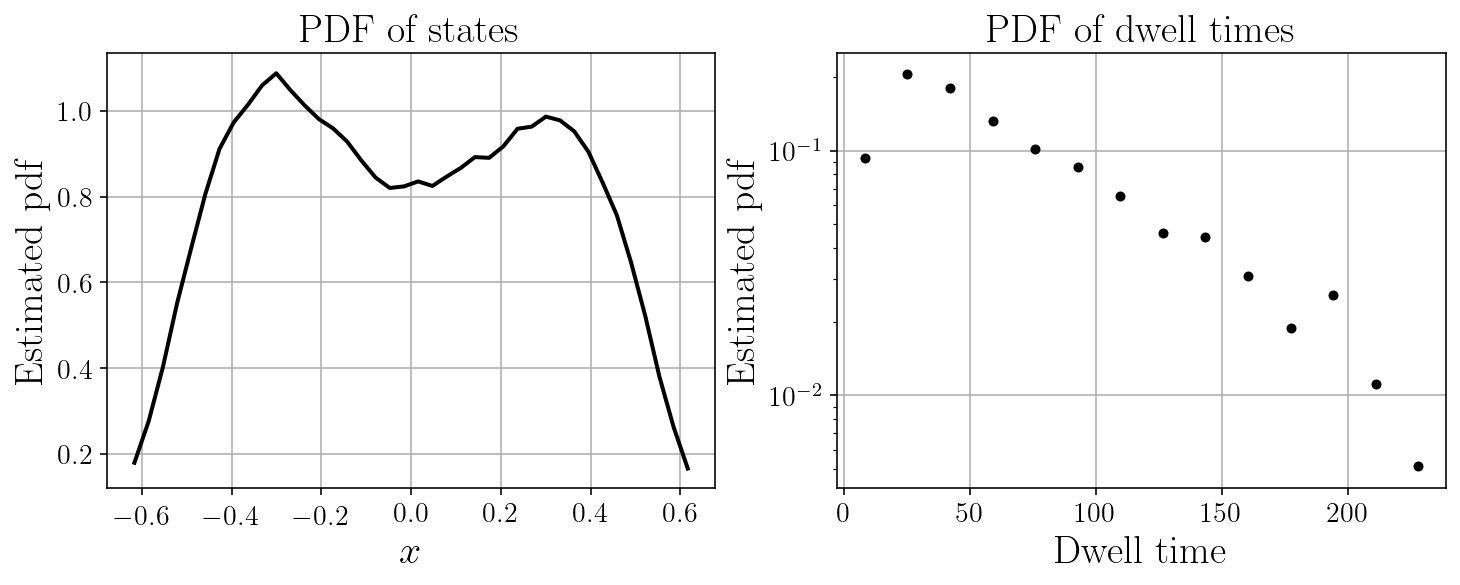

In [126]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(centers, p_hist, 'k', lw=2)
#plt.gca().set_yscale('log')
#plt.ylim([1e-2, 1e1])
plt.title('PDF of states')
plt.xlabel('$x$')
plt.ylabel('Estimated pdf')
plt.grid()

plt.subplot(122)
plt.errorbar(dwell_centers, pd, yerr=pd_err, c='k', ls='', marker='o', ms=4)
plt.gca().set_yscale('log')
plt.title('PDF of dwell times')

plt.xlabel('Dwell time')
plt.ylabel('Estimated pdf')
plt.grid()
plt.show()

### Normal form

In [127]:
lamb1 = -1 + np.sqrt(1 + eps)
lamb2 = -1 - np.sqrt(1 + eps)
h = -lamb1/lamb2
mu = -(1+h)**2*lamb1/eps
print(h, mu)

dt = 1e-2
tmax = int(1e5)
_, phi1 = jl.run_nf(lamb1, mu, sigma/(2*np.sqrt(1+eps)), dt, tmax)
X_nf = (1+h)*phi1[0, :]

0.0238230365969691 -0.5116209895339087


In [128]:
switch_nf = dw.dwell_times( dw.switched_states(X_nf, thresh=x_eq), dt=dt)

pd_nf = np.histogram(switch_nf, bins)[0]
pd_nf_err = np.sqrt(pd_nf)/np.trapz(pd_nf, dx=db)
pd_nf = pd_nf/np.trapz(pd_nf)

# Fit to exponential
if len(switch_nf)>0:
    slope_nf, cov = np.polyfit(dwell_centers[pd_nf > 1e-12], np.log(pd_nf[pd_nf > 1e-12]), deg=1, cov=True)
    slope_nf_err = np.sqrt(cov[0, 0])
    slope_nf = slope_nf[0]
else:
    slope_nf, slope_nf_err = np.nan, np.nan

# Mean escape times
print("Data mean: {0:0.3f}".format(np.mean(switch_times)))
print("Normal form mean: {0:0.3f}".format(np.mean(switch_nf)))

print("Slope: {0:0.3f} +/- {1:0.3f}".format(slope, slope_err))
print("NF slope: {0:0.3f} +/- {1:0.3f}".format(slope_nf, slope_nf_err))

Data mean: 78.769
Normal form mean: 69.715
Slope: -0.014 +/- 0.002
NF slope: -0.015 +/- 0.001


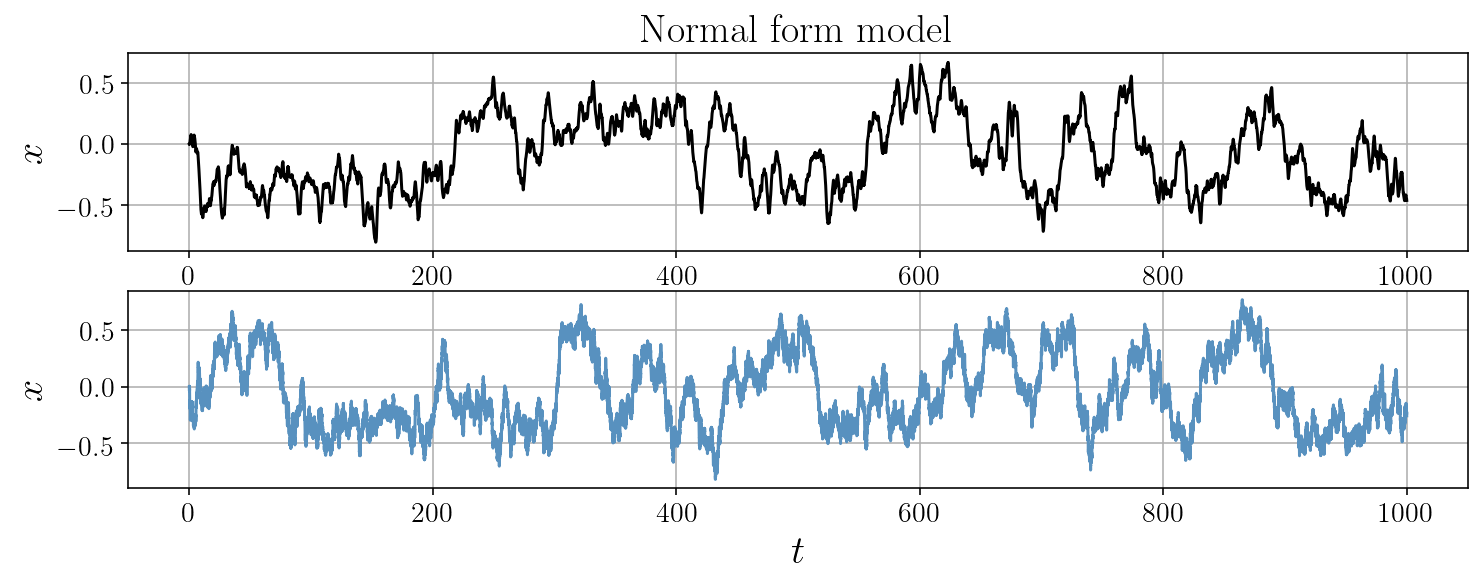

In [129]:
plt.figure(figsize=(12, 4))

tmax = np.nonzero(t>1000)[0][0]

plt.subplot(211)
stride=1
plt.plot(t[:tmax:stride], X[:tmax:stride], c=cm(0))
plt.ylabel('$x$')
plt.title('Normal form model')
plt.grid()

plt.subplot(212)
plt.plot(t[:tmax:stride], X_nf[:tmax:stride], c=cm(1))
plt.ylabel('$x$')
plt.xlabel("$t$")
plt.grid()
plt.show()

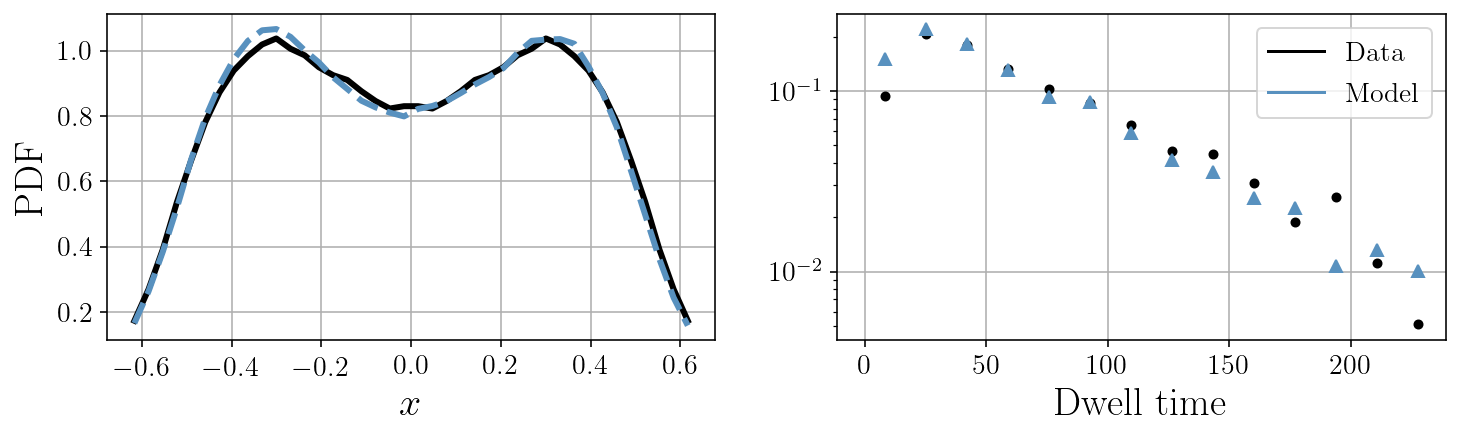

In [130]:
p_nf = np.histogram(X_nf, edges, density=True)[0]

plt.figure(figsize=(12, 3))

plt.subplot(121)
plt.plot(centers, 0.5*(p_hist + np.flip(p_hist)), c=cm(0), lw=3)
plt.plot(centers, p_nf, c=cm(1), ls='--', lw=3)
plt.xlabel('$x$')
plt.ylabel('PDF')
plt.grid()

plt.subplot(122)
plt.errorbar(dwell_centers, pd, yerr=pd_err, c=cm(0), ls='', marker='o', ms=4)
plt.errorbar(dwell_centers, pd_nf, yerr=pd_nf_err, c=cm(1), ls='', marker='^', ms=6)
plt.plot([0], [0], c=cm(0), label='Data')
plt.plot([0], [0], c=cm(1), label='Model')
plt.legend(fontsize=14)
plt.gca().set_yscale('log')

plt.xlabel('Dwell time')
plt.grid()
plt.show()

### Langevin regresion

In [143]:
# Plot truth, fast sampling, slow sampling

stride = 200
tau = stride*dt
print("Tau: {0}".format(tau))

Y = X[::stride] 
dY = (Y[1:] - Y[:-1])/tau  # Step (finite-difference derivative estimate)
dY2 = (Y[1:] - Y[:-1])**2/tau  # Conditional variance

dX = (X[1:] - X[:-1])/dt  # Step (finite-difference derivative estimate)
dX2 = (X[1:] - X[:-1])**2/dt  # Conditional variance

f_fine = np.zeros(centers.shape)
a_fine = np.zeros(centers.shape)
f_fine_err = np.zeros(centers.shape)
a_fine_err = np.zeros(centers.shape)
f_KM = np.zeros(centers.shape)
a_KM = np.zeros(centers.shape)
f_err = np.zeros(centers.shape)
a_err = np.zeros(centers.shape)

for i in range(len(edges)-1):
    # Fine sampling
    mask = np.nonzero( (X[:-1] > edges[i]) * (X[:-1] < edges[i+1]) )[0]
    
    if len(mask)>0:
        f_fine[i] = np.mean(dX[mask]) # Conditional average
        a_fine[i] = 0.5*np.mean(dX2[mask]) # Conditional average
        f_fine_err[i] = np.std(dX[mask])/np.sqrt(len(mask))
        a_fine_err[i] = np.std(dX2[mask])/np.sqrt(len(mask))
    else:
        f_fine[i], a_fine[i] = np.nan, np.nan

    # Coarse sampling
    mask = np.nonzero((Y[:-1] > edges[i]) * (Y[:-1] < edges[i+1]))[0]
    if len(mask)>0:
        f_KM[i] = np.mean(dY[mask]) # Conditional average
        a_KM[i] = 0.5*np.mean(dY2[mask]) # Conditional average
        f_err[i] = np.std(dY[mask])/np.sqrt(len(mask))
        a_err[i] = np.std(dY2[mask])/np.sqrt(len(mask))
    else:
        f_KM[i], a_KM[i] = np.nan, np.nan
        f_err[i], a_err[i] = np.nan, np.nan

Tau: 2.0


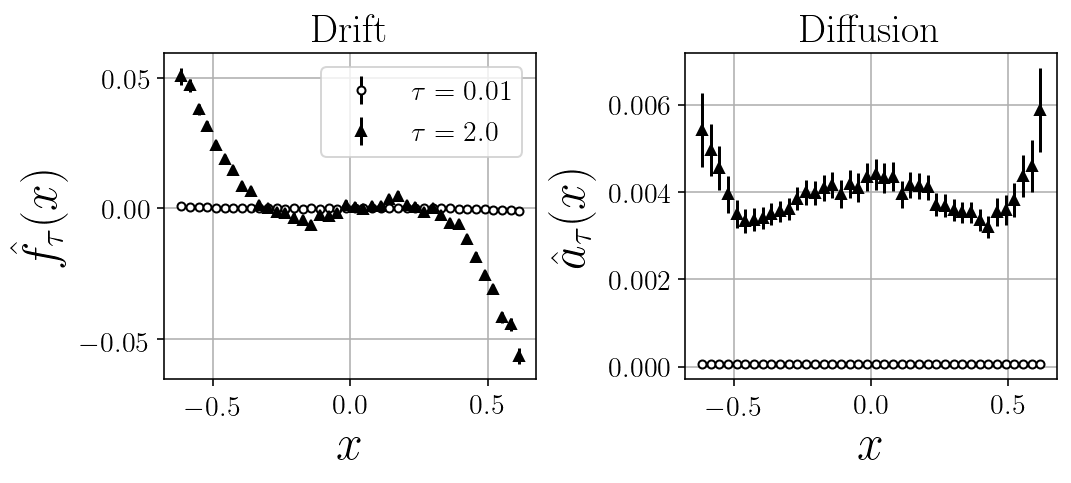

In [144]:


plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.errorbar(centers, f_fine, yerr=f_fine_err, ls='', marker='.', markersize=8, 
             c='k', markerfacecolor='w', label=r'$\tau = {{{0}}}$'.format(dt))
plt.errorbar(centers, f_KM, yerr=f_err, ls='', marker='^', markersize=5, 
             c='k', label=r'$\tau = {{{0}}}$'.format(tau))
plt.title('Drift')
plt.xlabel('$x$', fontsize = 24)
plt.ylabel(r'$\hat{f}_\tau(x)$', fontsize = 24)
plt.grid()
plt.legend(fontsize=14)
#plt.xlim([-1.8, 1.8])
#plt.ylim([-4, 4])


plt.subplot(122)
plt.errorbar(centers, a_fine, yerr=a_fine_err, ls='', marker='.', markersize=8, 
             c='k', markerfacecolor='w')
plt.errorbar(centers, a_KM, yerr=a_err, ls='', marker='^', markersize=5, 
             c='k')
plt.title('Diffusion')
plt.xlabel('$x$', fontsize = 24)
plt.ylabel(r'$\hat{a}_\tau(x)$', fontsize = 24)
plt.grid()
#plt.xlim([-1.8, 1.8])
#plt.ylim([0, 2])

plt.subplots_adjust(wspace=0.4)
plt.show()

### AFP optimization

In [145]:
### Build libraries
x = sympy.symbols('x')

f_expr = np.array([x**i for i in [1, 3]])  # Polynomial library for drift
s_expr = np.array([x**i for i in [0]])  # Polynomial library for diffusion

lib_f = np.zeros([len(f_expr), N])
for k in range(len(f_expr)):
    lamb_expr = sympy.lambdify(x, f_expr[k])
    lib_f[k] = lamb_expr(centers)

lib_s = np.zeros([len(s_expr), N])
for k in range(len(s_expr)):
    lamb_expr = sympy.lambdify(x, s_expr[k])
    lib_s[k] = lamb_expr(centers)
    
# Initialize Xi
Xi0 = np.zeros((len(f_expr) + len(s_expr)))
mask = np.nonzero(np.isfinite(f_KM))[0]
Xi0[:len(f_expr)] = lstsq( lib_f[:, mask].T, f_KM[mask], rcond=None)[0]
Xi0[len(f_expr):] = lstsq( lib_s[:,mask].T, np.sqrt(2*a_KM[mask]), rcond=None)[0]

print(Xi0)

[ 0.02481475 -0.30422857  0.08916804]


In [147]:
### Weights: uncertainties in Kramers-Moyal
W = np.array((f_err.flatten(), a_err.flatten()))
W[np.less(abs(W), 1e-12, where=np.isfinite(W))] = 1e6  # Set zero entries to large weights
W[np.logical_not(np.isfinite(W))] = 1e6                 # Set NaN entries to large numbers (small weights)
W = 1/W  # Invert error for weights
W = W/np.nansum(W.flatten())

# PDF
p_hist = np.histogram(X, edges, density=True)[0]

# Adjoint solver
afp = fpsolve.AdjFP(centers)

# Forward solver
fp = fpsolve.SteadyFP(N, centers[1]-centers[0])

params = {"W": W, "f_KM": f_KM, "a_KM": a_KM, "Xi0": Xi0,
          "f_expr": f_expr, "s_expr": s_expr,
          "lib_f": lib_f.T, "lib_s": lib_s.T, "N": N,
          "kl_reg": 0.1,
          "fp": fp, "afp": afp, "p_hist": p_hist, "tau": tau,
          "radial": False}

Xi, V = utils.AFP_opt(dw.cost, params)
print(Xi)

%%%% Optimization time: 0.39965200424194336 seconds,   Cost: 4.358582838992337e-07 %%%%
[ 0.04681703 -0.42982162  0.09160471]


In [148]:
Xi_f = Xi[:len(f_expr)]
Xi_s = Xi[len(f_expr):]

# Functions from the expressions

f_sindy = sympy.lambdify(x, utils.sindy_model(Xi_f, f_expr))
s_sindy = sympy.lambdify(x, utils.sindy_model(Xi_s, s_expr))
a_sindy = lambda x: 0.5*s_sindy(x)**2

f_vals = f_sindy(centers)
a_vals = a_sindy(centers)

# Check if a scalar (happens when library is a constant)
if np.isscalar(a_vals):
    a_vals = a_vals + 0*centers
if np.isscalar(f_vals):
    f_vals = f_vals + 0*centers

KL divergence (LINDy model): 0.00067


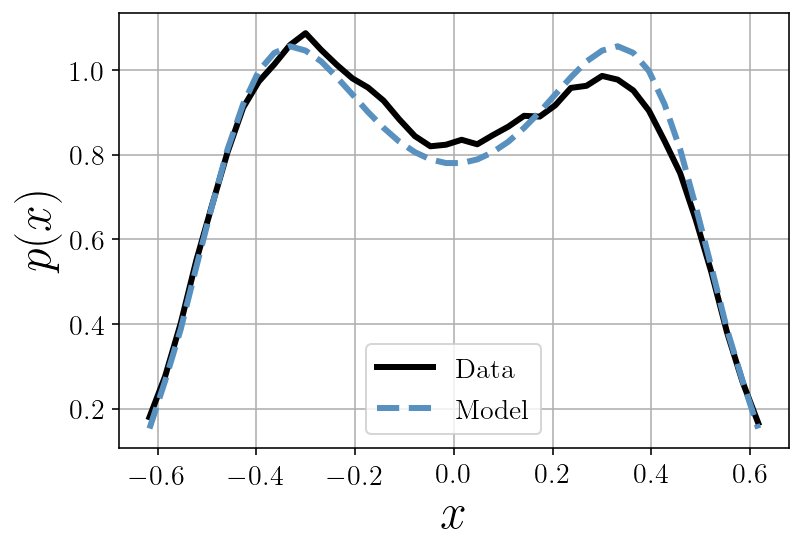

In [149]:
# Compare PDFs

p_fit = fp.solve(f_vals, a_vals)
print('KL divergence (LINDy model): {0:0.5f}'.format(utils.kl_divergence(p_hist, p_fit, dx=fp.dx, tol=1e-6)))

plt.figure(figsize=(6, 4))
plt.plot(centers, p_hist, c=cm(0), label='Data', lw=3)
plt.plot(centers, p_fit, '--', c=cm(1), label='Model', lw=3)
plt.legend(fontsize=14)
#plt.gca().set_yscale('log')
#plt.xlim([0, 3])
plt.xlabel('$x$', fontsize = 24)
plt.ylabel('$p(x)$', fontsize = 24)
plt.grid()

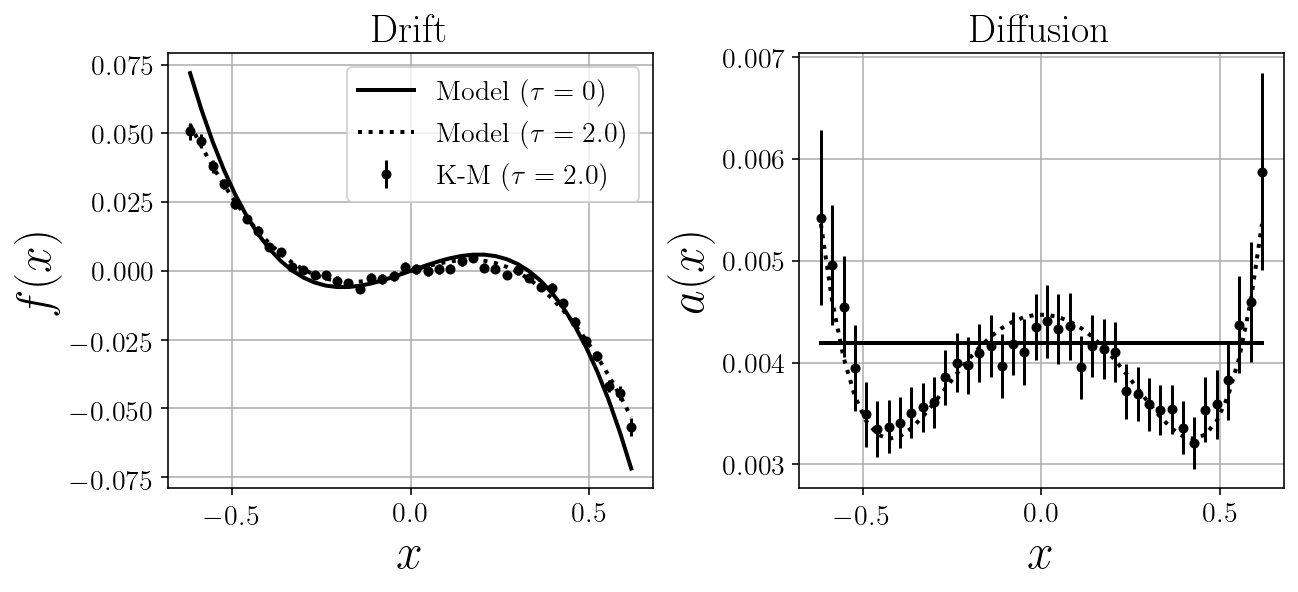

In [150]:
# Plot predicted finite-time evolution
afp.precompute_operator(f_vals, a_vals)
f_tau, a_tau = afp.solve(tau)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.errorbar(centers, f_KM, f_err, ls='', marker='.', markersize=8, 
             c='k', label=r'K-M  ($\tau = {{{0}}}$)'.format(tau))
plt.plot(centers, f_vals, 'k', lw=2, label=r'Model ($\tau = 0$)')
plt.plot(centers, f_tau, 'k:', lw=2, label=r'Model ($\tau = {{{0}}}$)'.format(tau))
plt.title('Drift')
plt.legend(fontsize=14)
plt.xlabel('$x$', fontsize = 24)
plt.ylabel('$f(x)$', fontsize = 24)
plt.grid()
#plt.xlim([-1.5, 1.5])
#plt.ylim([-10, 10])


plt.subplot(122)
plt.errorbar(centers, a_KM, a_err, ls='', marker='.', markersize=8, 
             c='k', label=r'K-M  ($\tau = {{{0}}}$)'.format(tau))
plt.plot(centers, a_vals, 'k', lw=2, label=r'Model ($\tau = 0$)')
plt.plot(centers, a_tau, 'k:', lw=2, label=r'Model ($\tau = {{{0}}}$)'.format(tau))
#plt.legend(fontsize=14)
plt.title('Diffusion')
plt.xlabel('$x$', fontsize = 24)
plt.ylabel('$a(x)$', fontsize = 24)
plt.grid()
#plt.xlim([-1.8, 1.8])
#plt.ylim([0,1.2])

plt.subplots_adjust(wspace=0.3)
plt.show()

### Monte Carlo model validation

In [151]:
# Can reuse normal form code for pitchfork models

dt = 1e-2
tmax = int(1e5)
_, X_lr = jl.run_nf(Xi[0], Xi[1], Xi[2], dt, tmax)
X_lr = X_lr[0, :]

In [152]:
switch_lr = dw.dwell_times( dw.switched_states(X_lr, thresh=x_eq), dt=dt)

pd_lr = np.histogram(switch_lr, bins)[0]
pd_lr_err = np.sqrt(pd_lr)/np.trapz(pd_lr, dx=db)
pd_lr = pd_lr/np.trapz(pd_lr)


# Fit to exponential
slope_lr, cov = np.polyfit(dwell_centers[pd_lr > 1e-12], np.log(pd_lr[pd_lr > 1e-12]), deg=1, cov=True)
slope_lr_err = np.sqrt(cov[0, 0])
slope_lr = slope_lr[0]

# Mean escape times
print("Data mean: {0:0.2f} +/- {1:0.2f}".format(np.mean(switch_times),
      np.std(switch_times)/np.sqrt(len(switch_times))))
print("Normal form mean: {0:0.2f} +/- {1:0.2f}".format(np.mean(switch_nf),
      np.std(switch_nf)/np.sqrt(len(switch_nf))))
print("PDF fit mean: {0:0.2f} +/- {1:0.2f}".format(np.mean(switch_pdf),
      np.std(switch_pdf)/np.sqrt(len(switch_pdf))))
print("Langevin regression mean: {0:0.2f} +/- {1:0.2f}".format(np.mean(switch_lr),
      np.std(switch_lr)/np.sqrt(len(switch_lr))))

print("Slope: {0:0.3f} +/- {1:0.3f}".format(slope, slope_err))
print("NF slope: {0:0.3f} +/- {1:0.3f}".format(slope_nf, slope_nf_err))
print("PDF slope: {0:0.3f} +/- {1:0.3f}".format(slope_pdf, slope_pdf_err))
print("LR slope: {0:0.3f} +/- {1:0.3f}".format(slope_lr, slope_lr_err))

Data mean: 78.77 +/- 1.92
Normal form mean: 69.71 +/- 1.61
PDF fit mean: 78.22 +/- 1.90
Langevin regression mean: 89.84 +/- 2.38
Slope: -0.014 +/- 0.002
NF slope: -0.015 +/- 0.001
PDF slope: -0.013 +/- 0.001
LR slope: -0.011 +/- 0.001


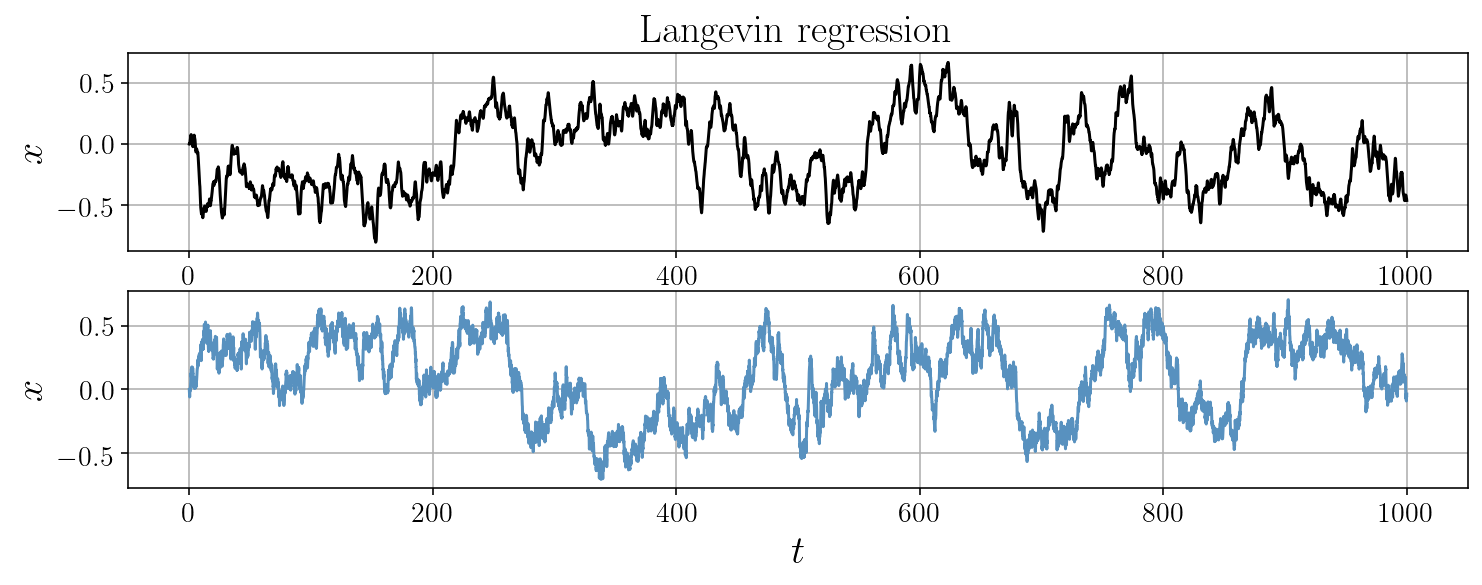

In [153]:
plt.figure(figsize=(12, 4))

tmax = np.nonzero(t>1000)[0][0]

plt.subplot(211)
stride=10
plt.plot(t[:tmax:stride], X[:tmax:stride], c=cm(0))
plt.ylabel('$x$')
plt.title('Langevin regression')
plt.grid()

plt.subplot(212)
stride=10
plt.plot(t[:tmax:stride], X_lr[:tmax:stride], c=cm(1))
plt.ylabel('$x$')
plt.xlabel("$t$")
plt.grid()
plt.show()

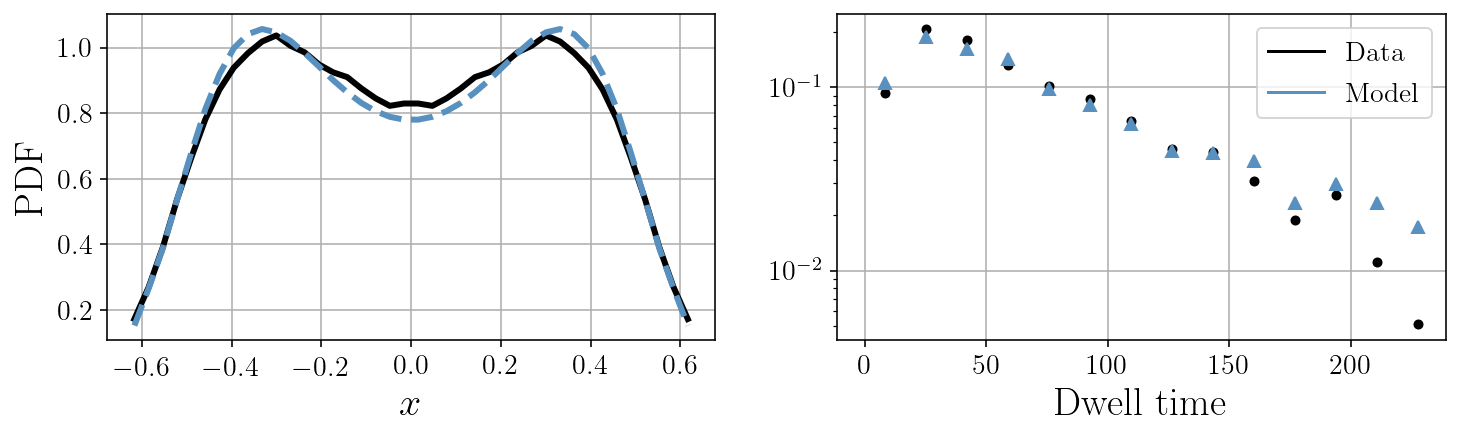

In [154]:
plt.figure(figsize=(12, 3))

plt.subplot(121)
plt.plot(centers, 0.5*(p_hist + np.flip(p_hist)), c=cm(0), lw=3)
plt.plot(centers, p_fit, c=cm(1), ls='--', lw=3)
plt.xlabel('$x$')
plt.ylabel('PDF')
plt.grid()

plt.subplot(122)
plt.errorbar(dwell_centers, pd, yerr=pd_err, c=cm(0), ls='', marker='o', ms=4)
plt.errorbar(dwell_centers, pd_lr, yerr=pd_lr_err, c=cm(1), ls='', marker='^', ms=6)
plt.plot([0], [0], c=cm(0), label='Data')
plt.plot([0], [0], c=cm(1), label='Model')
plt.legend(fontsize=14)
plt.gca().set_yscale('log')

plt.xlabel('Dwell time')
plt.grid()
plt.show()

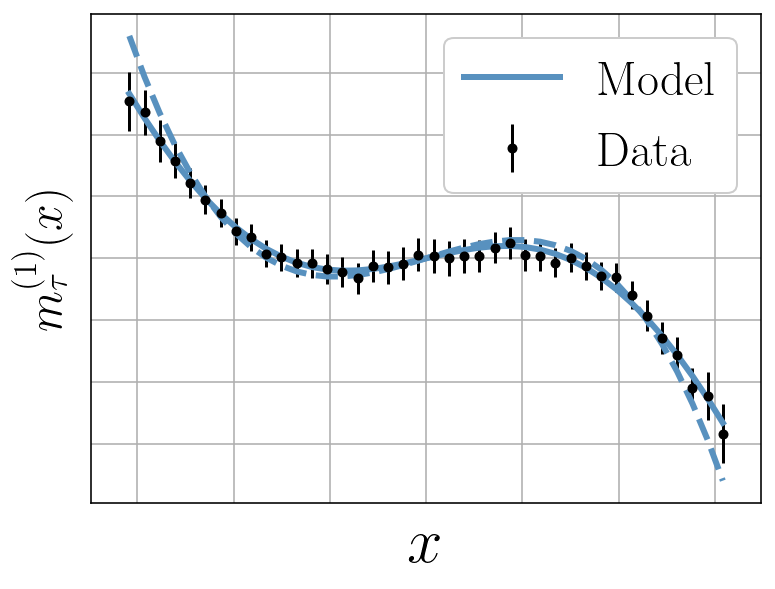

In [156]:
# Plot predicted finite-time evolution
afp.precompute_operator(f_vals, a_vals)
f_tau, a_tau = afp.solve(tau)

plt.figure(figsize=(6, 4.5))
plt.errorbar(centers, f_KM, 3*f_err, ls='', marker='.', markersize=8, 
             c='k', label=r'Data')
plt.plot(centers, f_vals, c=cm(1), lw=3, ls='--')
plt.plot(centers, f_tau, c=cm(1), lw=3, label=r'Model')
plt.legend(fancybox=True, framealpha=1, fontsize=24, loc=1)
plt.xlabel('$x$', fontsize=32)
plt.ylabel(r'$m^{(1)}_\tau(x)$', fontsize=24)
plt.grid()
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.gca().tick_params('both', length=0)
plt.xlim([-2.2*x_eq, 2.2*x_eq])
#plt.ylim([-0.2, 0.2])

plt.show()

# Compare models w/ distance from bifurcation

In [669]:
eps = np.logspace(-2, 1, 15)
sigma = 0.5*(np.sqrt(eps) + eps)
dw = reload(dw)

In [670]:
# Bins for state distribution
N = 40

b = np.zeros((4, len(eps)))
kl_div = np.zeros((3, len(eps)))
for i in range(len(eps)):
    print("eps: {0:0.2f}".format(eps[i]))
    b[:, i], kl_div[:, i] = dw.model_eval(eps[i], sigma[i], N, kl_reg=0.1)

eps: 0.01
	Data:  151.9447112462006 6.02869809055146
	Normal form:  123.80623296158613 4.024465141314444
	PDF fit:  136.5154120879121 4.666709449844053
%%%% Optimization time: 0.383281946182251 seconds,   Cost: 1.1679045913988515e-08 %%%%
	Langevin regression:  165.08110927152316 6.365254485169543
	KL div:  0.0013338766397591687 0.0004765512002360759 0.0014176450820100862
eps: 0.02
	Data:  134.05994630872485 4.583787340148837
	Normal form:  109.04054525627043 3.430947520406497
	PDF fit:  125.10699248120301 3.9520152137239135
%%%% Optimization time: 0.2633359432220459 seconds,   Cost: 2.4218042327349054e-08 %%%%
	Langevin regression:  154.9857984496124 5.861692171264501
	KL div:  0.002192993894834068 0.000942739754987081 0.0006311209002541418
eps: 0.03
	Data:  112.76437923250565 3.2072552058743553
	Normal form:  99.34700497512438 2.8626323403342946
	PDF fit:  108.31582881906827 3.118742852012529
%%%% Optimization time: 0.36456823348999023 seconds,   Cost: 6.577148935431179e-08 %%%%
	Lan

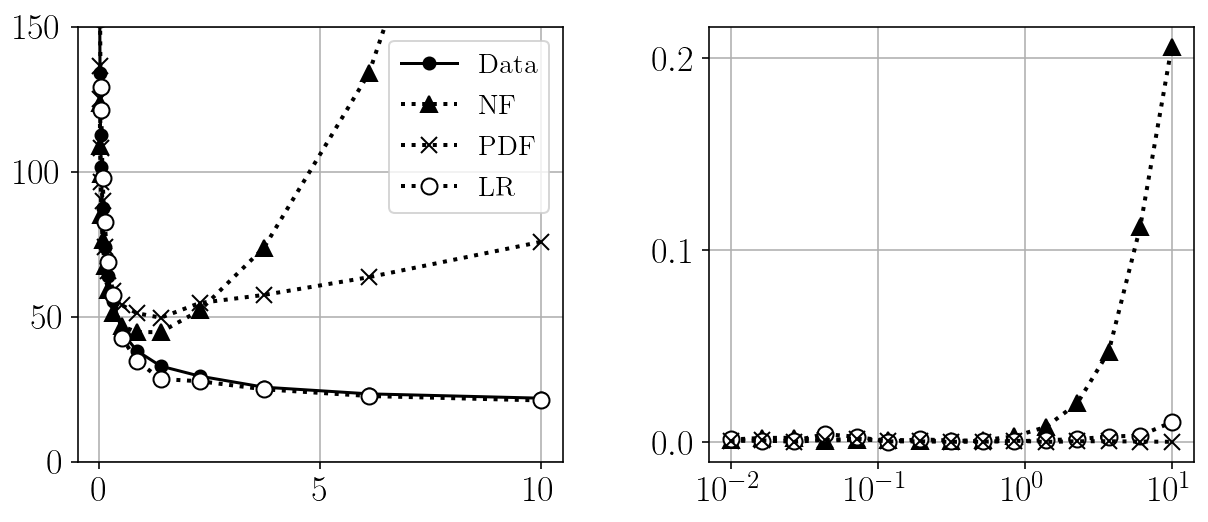

In [699]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(eps, b[0, :], 'ko-', label="Data")
plt.plot(eps, b[1, :], 'k^:', lw=2, ms=8)
plt.plot(eps, b[2, :], 'kx:', lw=2, ms=8)
plt.plot(eps, b[3, :], 'ko:', lw=2, ms=8, markerfacecolor='white')
plt.grid()
plt.legend(["Data", "NF", "PDF", "LR"], fontsize=14)
#plt.ylabel("Mean dwell time")
#plt.xlabel(r"Bifurcation parameter $\epsilon$")
plt.ylim([0, 150])
plt.gca().tick_params(labelsize=18)
plt.gca().set_yticks([0, 50, 100, 150])

plt.subplot(122)
plt.loglog(eps, kl_div[0, :], 'k^:', lw=2, ms=8)
plt.loglog(eps, kl_div[2, :], 'ko:', lw=2, ms=8, markerfacecolor='white')
plt.loglog(eps, kl_div[1, :], 'kx:', lw=2, ms=8)
plt.grid()
#plt.ylabel(r"$\mathcal{D}_{KL}$")
#plt.xlabel(r"Bifurcation parameter $\epsilon$")
plt.gca().set_yscale('linear')
plt.gca().tick_params(labelsize=18)
plt.gca().set_xticks([1e-2, 1e-1, 1e0, 1e1])
plt.gca().set_yticks([0.0, 0.1, 0.2])

plt.subplots_adjust(wspace=0.3)
plt.show()